## S9 - Advanced Concepts, Data Augmentation & Visualizations

#### Target:
    No of parameters should be less than 50k.
    Accuracy of model should be between 70 and 94 which should be achieved in 20 epochs.

#### Result:
    No of parameters of model: 48512
    Test Accuracy: 77.8%
    Trained for 20 epochs and used less than 50k params.

#### Analysis:

    Model is overfitting.
    There was faster convergence with BN as it was applied on every layer.
    No of paremeters introduced through BN layer are less than Layer Normalization.
    Batch Normalization is used on every layer other than prediction layer.
    I see it misclassified many images as cat.


### Import heavenly gods / libraries

In [25]:
from __future__ import print_function
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np

In [26]:
!pip install albumentations

In [27]:
import albumentations
import albumentations.pytorch

## Data Transformations using albumentation

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [28]:
class Transforms:
    def __init__(self, transforms: albumentations.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

In [29]:
# Train Phase transformations
albumentations_train_transform = albumentations.Compose([
    albumentations.HorizontalFlip(),
    albumentations.ShiftScaleRotate(),
    albumentations.CoarseDropout(max_holes=1, max_height = 16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.49139968, 0.48215827 ,0.44653124,), mask_fill_value = None),
    albumentations.augmentations.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124,), (0.24703233,0.24348505,0.26158768,)),
        albumentations.pytorch.transforms.ToTensorV2()
])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124,), (0.24703233,0.24348505,0.26158768,))
                                       ])

## Load CIFAR10 dataset

In [30]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=Transforms(albumentations_train_transform))
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Dataloader Arguments and Train/Test Dataloaders

In [31]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Statistics

* Compute mean , standard deviation, variance of training data
* Visualizing images in a batch

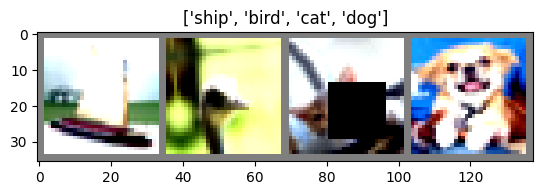

In [32]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already

def imshow(img, labels):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(labels)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images['image']
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

imshow(make_grid(images[0:4]), [classes[index] for index in labels.tolist()[0:4]])


# Define model for batch normalization

C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11

In [53]:
class Model_S9(nn.Module):
    def __init__(self):
        super(Model_S9, self).__init__()
        self.dropout_value = 0.05
        # CONVOLUTION BLOCK 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # RF = 3
        self.conv_dilation1 = self.conv_block_with_dilation(16, 16, 2, 1)  # RF = 11
        self.depth_wise1 = self.depth_wise_seperable_conv(16, 32) # RF = 13
        self.conv_dilation2 = self.conv_block_with_dilation(32, 32, 2, 0) # RF = 21
        self.depth_wise2 = self.depth_wise_seperable_conv(32, 48) # RF = 23
        self.conv_dilation3 = self.conv_block_with_dilation(48, 48, 2, 0) # RF = 31
        self.depth_wise3 = self.depth_wise_seperable_conv(48, 64) # RF = 33
        self.conv_dilation4 = self.conv_block_with_dilation(64, 64, 2, 0, last_block=True) # RF = 41
        self.depth_wise4 = self.depth_wise_seperable_conv(64, 80) # RF = 43

       # output_size = 8
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # RF = 57

        # OUTPUT BLOCK
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=80, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1

    def depth_wise_seperable_conv(self, n_in, n_out):
        depthwise_seperable = nn.Sequential(
            nn.Conv2d(in_channels=n_in, out_channels=n_in, kernel_size=(3, 3), padding=1, bias=False, groups=n_in),
            nn.BatchNorm2d(n_in),
            nn.ReLU(),
            nn.Dropout(self.dropout_value),
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(n_out),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        return depthwise_seperable

    def conv_block_with_dilation(self, n_in, n_out, dilation_val, padding_val, last_block=False):
      if last_block:
        conv_block = nn.Sequential(
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=(3, 3), padding=padding_val, bias=False),
            nn.BatchNorm2d(n_out),
            nn.ReLU(),
            nn.Dropout(self.dropout_value),
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=(3, 3), padding=padding_val, bias=False, dilation=dilation_val),
            nn.BatchNorm2d(n_out),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )
      else:

        conv_block = nn.Sequential(
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=(3, 3), padding=padding_val, bias=False),
            nn.BatchNorm2d(n_out),
            nn.ReLU(),
            nn.Dropout(self.dropout_value),
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=(3, 3), padding=padding_val, bias=False),
            nn.BatchNorm2d(n_out),
            nn.ReLU(),
            nn.Dropout(self.dropout_value),
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=(3, 3), padding=padding_val, bias=False, dilation=dilation_val),
            nn.BatchNorm2d(n_out),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

      return conv_block



    def forward(self, x):
        x = self.conv1(x)
        x = self.conv_dilation1(x)
        x = self.depth_wise1(x)
        x = self.conv_dilation2(x)
        x = self.depth_wise2(x)
        x = self.conv_dilation3(x)
        x = self.depth_wise3(x)
        x = self.conv_dilation4(x)
        x = self.depth_wise4(x)
        x = self.gap(x)
        x = self.conv2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
from model import Model_4

## Model summary

In [54]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_nn = Model_S9().to(device)
summary(model_nn, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,304
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
          Dropout-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 30, 30]           2,304
      BatchNorm2d-14           [-1

### Functions to train and test the data

In [61]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data['image'].to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

* Specified LR Scheduler ( ReduceLROnPlateau ).
* Training data for 20 epochs
* Using SGD as optimizer


In [62]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model_nn =  Model_S9().to(device)
optimizer = optim.SGD(model_nn.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel')
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_nn, device, train_loader, optimizer, epoch)
    test_loss = test(model_nn, device, test_loader)
    scheduler.step(test_loss)
    print("LR: ", scheduler.get_last_lr())

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.768963098526001 Batch_id=390 Accuracy=27.17: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]



Test set: Average loss: 1.6747, Accuracy: 3930/10000 (39.30%)

LR:  [0.01]
EPOCH: 1


Loss=1.4861546754837036 Batch_id=390 Accuracy=37.22: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]



Test set: Average loss: 1.7247, Accuracy: 3762/10000 (37.62%)

LR:  [0.01]
EPOCH: 2


Loss=1.481533408164978 Batch_id=390 Accuracy=41.85: 100%|██████████| 391/391 [00:19<00:00, 19.94it/s]



Test set: Average loss: 1.4848, Accuracy: 4698/10000 (46.98%)

LR:  [0.01]
EPOCH: 3


Loss=1.4247186183929443 Batch_id=390 Accuracy=45.61: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]



Test set: Average loss: 1.3798, Accuracy: 5014/10000 (50.14%)

LR:  [0.01]
EPOCH: 4


Loss=1.4600307941436768 Batch_id=390 Accuracy=48.36: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]



Test set: Average loss: 1.1762, Accuracy: 5694/10000 (56.94%)

LR:  [0.01]
EPOCH: 5


Loss=1.3788219690322876 Batch_id=390 Accuracy=50.41: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]



Test set: Average loss: 1.1746, Accuracy: 5698/10000 (56.98%)

LR:  [0.01]
EPOCH: 6


Loss=1.4520509243011475 Batch_id=390 Accuracy=52.11: 100%|██████████| 391/391 [00:19<00:00, 20.31it/s]



Test set: Average loss: 1.2158, Accuracy: 5614/10000 (56.14%)

LR:  [0.01]
EPOCH: 7


Loss=1.3031123876571655 Batch_id=390 Accuracy=53.41: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]



Test set: Average loss: 1.1206, Accuracy: 5932/10000 (59.32%)

LR:  [0.01]
EPOCH: 8


Loss=1.2666585445404053 Batch_id=390 Accuracy=55.03: 100%|██████████| 391/391 [00:19<00:00, 20.24it/s]



Test set: Average loss: 1.0590, Accuracy: 6234/10000 (62.34%)

LR:  [0.01]
EPOCH: 9


Loss=0.9060283899307251 Batch_id=390 Accuracy=56.32: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s]



Test set: Average loss: 1.0026, Accuracy: 6403/10000 (64.03%)

LR:  [0.01]
EPOCH: 10


Loss=1.08175528049469 Batch_id=390 Accuracy=57.42: 100%|██████████| 391/391 [00:18<00:00, 20.65it/s]



Test set: Average loss: 0.9793, Accuracy: 6544/10000 (65.44%)

LR:  [0.01]
EPOCH: 11


Loss=1.2036315202713013 Batch_id=390 Accuracy=58.20: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s]



Test set: Average loss: 0.9557, Accuracy: 6624/10000 (66.24%)

LR:  [0.01]
EPOCH: 12


Loss=0.9704980850219727 Batch_id=390 Accuracy=59.25: 100%|██████████| 391/391 [00:19<00:00, 20.04it/s]



Test set: Average loss: 0.9354, Accuracy: 6706/10000 (67.06%)

LR:  [0.01]
EPOCH: 13


Loss=0.9640620350837708 Batch_id=390 Accuracy=59.99: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]



Test set: Average loss: 0.9268, Accuracy: 6799/10000 (67.99%)

LR:  [0.01]
EPOCH: 14


Loss=0.9770694971084595 Batch_id=390 Accuracy=60.91: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s]



Test set: Average loss: 0.8609, Accuracy: 7028/10000 (70.28%)

LR:  [0.01]
EPOCH: 15


Loss=1.073250412940979 Batch_id=390 Accuracy=61.33: 100%|██████████| 391/391 [00:19<00:00, 20.24it/s]



Test set: Average loss: 0.8408, Accuracy: 7041/10000 (70.41%)

LR:  [0.01]
EPOCH: 16


Loss=0.9273725748062134 Batch_id=390 Accuracy=62.00: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]



Test set: Average loss: 0.8985, Accuracy: 6783/10000 (67.83%)

LR:  [0.01]
EPOCH: 17


Loss=0.946850597858429 Batch_id=390 Accuracy=62.07: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.8124, Accuracy: 7139/10000 (71.39%)

LR:  [0.01]
EPOCH: 18


Loss=0.8873558044433594 Batch_id=390 Accuracy=62.63: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s]



Test set: Average loss: 0.8338, Accuracy: 7119/10000 (71.19%)

LR:  [0.01]
EPOCH: 19


Loss=1.1801228523254395 Batch_id=390 Accuracy=63.33: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]



Test set: Average loss: 0.8147, Accuracy: 7175/10000 (71.75%)

LR:  [0.01]
EPOCH: 20


Loss=1.1646698713302612 Batch_id=390 Accuracy=63.78: 100%|██████████| 391/391 [00:18<00:00, 20.64it/s]



Test set: Average loss: 0.7930, Accuracy: 7207/10000 (72.07%)

LR:  [0.01]
EPOCH: 21


Loss=0.91656893491745 Batch_id=390 Accuracy=63.72: 100%|██████████| 391/391 [00:18<00:00, 20.69it/s]



Test set: Average loss: 0.7912, Accuracy: 7264/10000 (72.64%)

LR:  [0.01]
EPOCH: 22


Loss=1.1802046298980713 Batch_id=390 Accuracy=64.21: 100%|██████████| 391/391 [00:19<00:00, 20.06it/s]



Test set: Average loss: 0.7768, Accuracy: 7303/10000 (73.03%)

LR:  [0.01]
EPOCH: 23


Loss=0.9815033078193665 Batch_id=390 Accuracy=64.63: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]



Test set: Average loss: 0.7491, Accuracy: 7447/10000 (74.47%)

LR:  [0.01]
EPOCH: 24


Loss=1.0714428424835205 Batch_id=390 Accuracy=64.89: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s]



Test set: Average loss: 0.7550, Accuracy: 7371/10000 (73.71%)

LR:  [0.01]
EPOCH: 25


Loss=0.968443751335144 Batch_id=390 Accuracy=65.15: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]



Test set: Average loss: 0.7471, Accuracy: 7435/10000 (74.35%)

LR:  [0.01]
EPOCH: 26


Loss=0.8916484713554382 Batch_id=390 Accuracy=65.55: 100%|██████████| 391/391 [00:19<00:00, 20.02it/s]



Test set: Average loss: 0.7980, Accuracy: 7220/10000 (72.20%)

LR:  [0.01]
EPOCH: 27


Loss=1.0600249767303467 Batch_id=390 Accuracy=65.89: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]



Test set: Average loss: 0.8026, Accuracy: 7246/10000 (72.46%)

LR:  [0.01]
EPOCH: 28


Loss=0.9357317686080933 Batch_id=390 Accuracy=66.17: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]



Test set: Average loss: 0.7253, Accuracy: 7513/10000 (75.13%)

LR:  [0.01]
EPOCH: 29


Loss=0.945875346660614 Batch_id=390 Accuracy=66.39: 100%|██████████| 391/391 [00:20<00:00, 19.24it/s]



Test set: Average loss: 0.7751, Accuracy: 7305/10000 (73.05%)

LR:  [0.01]
EPOCH: 30


Loss=1.0296131372451782 Batch_id=390 Accuracy=66.43: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s]



Test set: Average loss: 0.7360, Accuracy: 7453/10000 (74.53%)

LR:  [0.01]
EPOCH: 31


Loss=0.8746284246444702 Batch_id=390 Accuracy=66.71: 100%|██████████| 391/391 [00:19<00:00, 20.29it/s]



Test set: Average loss: 0.6961, Accuracy: 7580/10000 (75.80%)

LR:  [0.01]
EPOCH: 32


Loss=1.0086877346038818 Batch_id=390 Accuracy=67.27: 100%|██████████| 391/391 [00:18<00:00, 20.67it/s]



Test set: Average loss: 0.7398, Accuracy: 7422/10000 (74.22%)

LR:  [0.01]
EPOCH: 33


Loss=0.7756741046905518 Batch_id=390 Accuracy=67.75: 100%|██████████| 391/391 [00:19<00:00, 20.54it/s]



Test set: Average loss: 0.7723, Accuracy: 7270/10000 (72.70%)

LR:  [0.01]
EPOCH: 34


Loss=0.9233245849609375 Batch_id=390 Accuracy=67.34: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]



Test set: Average loss: 0.7015, Accuracy: 7539/10000 (75.39%)

LR:  [0.001]
EPOCH: 35


Loss=0.9126470685005188 Batch_id=390 Accuracy=69.22: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s]



Test set: Average loss: 0.6389, Accuracy: 7785/10000 (77.85%)

LR:  [0.001]
EPOCH: 36


Loss=0.7009787559509277 Batch_id=390 Accuracy=69.95: 100%|██████████| 391/391 [00:18<00:00, 20.61it/s]



Test set: Average loss: 0.6323, Accuracy: 7815/10000 (78.15%)

LR:  [0.001]
EPOCH: 37


Loss=0.7638078927993774 Batch_id=390 Accuracy=70.23: 100%|██████████| 391/391 [00:19<00:00, 20.04it/s]



Test set: Average loss: 0.6412, Accuracy: 7756/10000 (77.56%)

LR:  [0.001]
EPOCH: 38


Loss=0.7602429986000061 Batch_id=390 Accuracy=70.07: 100%|██████████| 391/391 [00:19<00:00, 19.84it/s]



Test set: Average loss: 0.6277, Accuracy: 7825/10000 (78.25%)

LR:  [0.001]
EPOCH: 39


Loss=0.8097121119499207 Batch_id=390 Accuracy=70.18: 100%|██████████| 391/391 [00:19<00:00, 20.32it/s]



Test set: Average loss: 0.6338, Accuracy: 7794/10000 (77.94%)

LR:  [0.001]
EPOCH: 40


Loss=0.7733911871910095 Batch_id=390 Accuracy=70.59: 100%|██████████| 391/391 [00:18<00:00, 20.66it/s]



Test set: Average loss: 0.6166, Accuracy: 7858/10000 (78.58%)

LR:  [0.001]
EPOCH: 41


Loss=0.7597684860229492 Batch_id=390 Accuracy=70.30: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]



Test set: Average loss: 0.6299, Accuracy: 7814/10000 (78.14%)

LR:  [0.001]
EPOCH: 42


Loss=0.8569952845573425 Batch_id=390 Accuracy=70.56: 100%|██████████| 391/391 [00:23<00:00, 16.40it/s]



Test set: Average loss: 0.6202, Accuracy: 7856/10000 (78.56%)

LR:  [0.001]
EPOCH: 43


Loss=0.9249642491340637 Batch_id=390 Accuracy=70.63: 100%|██████████| 391/391 [00:20<00:00, 19.54it/s]



Test set: Average loss: 0.6141, Accuracy: 7850/10000 (78.50%)

LR:  [0.001]
EPOCH: 44


Loss=0.996961236000061 Batch_id=390 Accuracy=70.43: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]



Test set: Average loss: 0.6154, Accuracy: 7850/10000 (78.50%)

LR:  [0.001]
EPOCH: 45


Loss=0.795228123664856 Batch_id=390 Accuracy=70.73: 100%|██████████| 391/391 [00:18<00:00, 20.69it/s]



Test set: Average loss: 0.6274, Accuracy: 7789/10000 (77.89%)

LR:  [0.001]
EPOCH: 46


Loss=0.9445611834526062 Batch_id=390 Accuracy=70.42: 100%|██████████| 391/391 [00:19<00:00, 19.95it/s]



Test set: Average loss: 0.6208, Accuracy: 7835/10000 (78.35%)

LR:  [0.0001]
EPOCH: 47


Loss=0.7970261573791504 Batch_id=390 Accuracy=70.71: 100%|██████████| 391/391 [00:19<00:00, 19.79it/s]



Test set: Average loss: 0.6160, Accuracy: 7866/10000 (78.66%)

LR:  [0.0001]
EPOCH: 48


Loss=0.8681610822677612 Batch_id=390 Accuracy=70.86: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s]



Test set: Average loss: 0.6152, Accuracy: 7874/10000 (78.74%)

LR:  [0.0001]
EPOCH: 49


Loss=0.977800726890564 Batch_id=390 Accuracy=70.74: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]



Test set: Average loss: 0.6125, Accuracy: 7887/10000 (78.87%)

LR:  [0.0001]


In [63]:
start = 50
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", start + epoch)
    train(model_nn, device, train_loader, optimizer, start + epoch)
    test_loss = test(model_nn, device, test_loader)
    scheduler.step(test_loss)
    print("LR: ", scheduler.get_last_lr())

EPOCH: 50


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.9167941808700562 Batch_id=390 Accuracy=70.93: 100%|██████████| 391/391 [00:19<00:00, 19.96it/s]



Test set: Average loss: 0.6155, Accuracy: 7856/10000 (78.56%)

LR:  [0.0001]
EPOCH: 51


Loss=1.1776742935180664 Batch_id=390 Accuracy=70.93: 100%|██████████| 391/391 [00:19<00:00, 19.81it/s]



Test set: Average loss: 0.6145, Accuracy: 7879/10000 (78.79%)

LR:  [0.0001]
EPOCH: 52


Loss=0.7165737152099609 Batch_id=390 Accuracy=70.86: 100%|██████████| 391/391 [00:20<00:00, 19.08it/s]



Test set: Average loss: 0.6159, Accuracy: 7875/10000 (78.75%)

LR:  [1e-05]
EPOCH: 53


Loss=0.9215741157531738 Batch_id=390 Accuracy=71.00: 100%|██████████| 391/391 [00:19<00:00, 19.70it/s]



Test set: Average loss: 0.6081, Accuracy: 7890/10000 (78.90%)

LR:  [1e-05]
EPOCH: 54


Loss=0.7166659832000732 Batch_id=390 Accuracy=70.72: 100%|██████████| 391/391 [00:19<00:00, 20.29it/s]



Test set: Average loss: 0.6135, Accuracy: 7889/10000 (78.89%)

LR:  [1e-05]
EPOCH: 55


Loss=0.6560731530189514 Batch_id=390 Accuracy=70.86: 100%|██████████| 391/391 [00:19<00:00, 19.77it/s]



Test set: Average loss: 0.6156, Accuracy: 7865/10000 (78.65%)

LR:  [1e-05]
EPOCH: 56


Loss=0.7495361566543579 Batch_id=390 Accuracy=70.92: 100%|██████████| 391/391 [00:19<00:00, 20.02it/s]



Test set: Average loss: 0.6161, Accuracy: 7872/10000 (78.72%)

LR:  [1.0000000000000002e-06]
EPOCH: 57


Loss=0.8365994691848755 Batch_id=343 Accuracy=71.04:  88%|████████▊ | 344/391 [00:17<00:02, 20.21it/s]


KeyboardInterrupt: 

In [59]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

### Plotted graph for training loss, testing loss, training and testing accuracy

Text(0.5, 1.0, 'Test Accuracy')

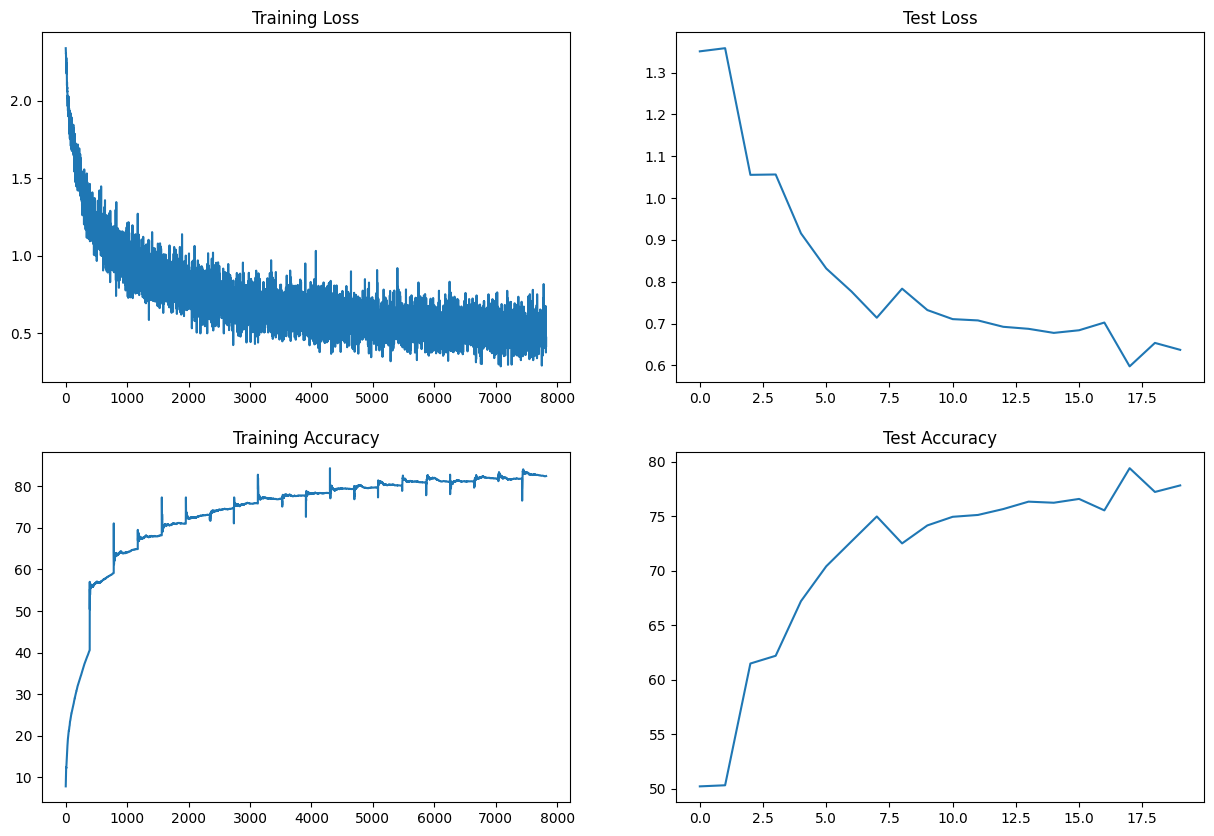

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Below code is written to find the misclassified images , labels and their correct labels.

In [ ]:
# get mismatched images
model_nn.eval()
misclassified_images = []
misclassified_image_labels = []
correct_image_labels = []
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_nn(data)
        pred = output.argmax(dim=1, keepdim=True)
        pred_classes = pred.squeeze().tolist()
        target_classes = target.view_as(pred).squeeze().tolist()
        for index in range(len(pred_classes)):
          if (pred_classes[index] != target_classes[index]):
            misclassified_images.append(data[index].cpu())
            misclassified_image_labels.append(class_labels[pred_classes[index]])
            correct_image_labels.append(class_labels[target_classes[index]])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Obtain first 10 misclassified images and their coreesponding ground truth ( actual values) and predicted values

In [ ]:
first_ten_misclassified_images = misclassified_images[0:10]
first_ten_misclassified_labels = misclassified_image_labels[0:10]
first_ten_correct_labels = correct_image_labels[0:10]

In [ ]:
grid_image = make_grid(first_ten_misclassified_images, nrow=5, normalize=True)

In [ ]:
grid_image.shape

torch.Size([3, 70, 172])

In [ ]:
misclassified_dict= {}
for index in range(0, len(first_ten_correct_labels)):
  misclassified_dict["GT." + str(index+1) + ": " + first_ten_correct_labels[index]] = "Pred: " + first_ten_misclassified_labels[index]

In [ ]:
misclassified_dict

{'GT.1: dog': 'Pred: cat',
 'GT.2: bird': 'Pred: airplane',
 'GT.3: cat': 'Pred: dog',
 'GT.4: dog': 'Pred: cat',
 'GT.5: truck': 'Pred: cat',
 'GT.6: bird': 'Pred: cat',
 'GT.7: horse': 'Pred: airplane',
 'GT.8: horse': 'Pred: cat',
 'GT.9: bird': 'Pred: deer',
 'GT.10: automobile': 'Pred: truck'}

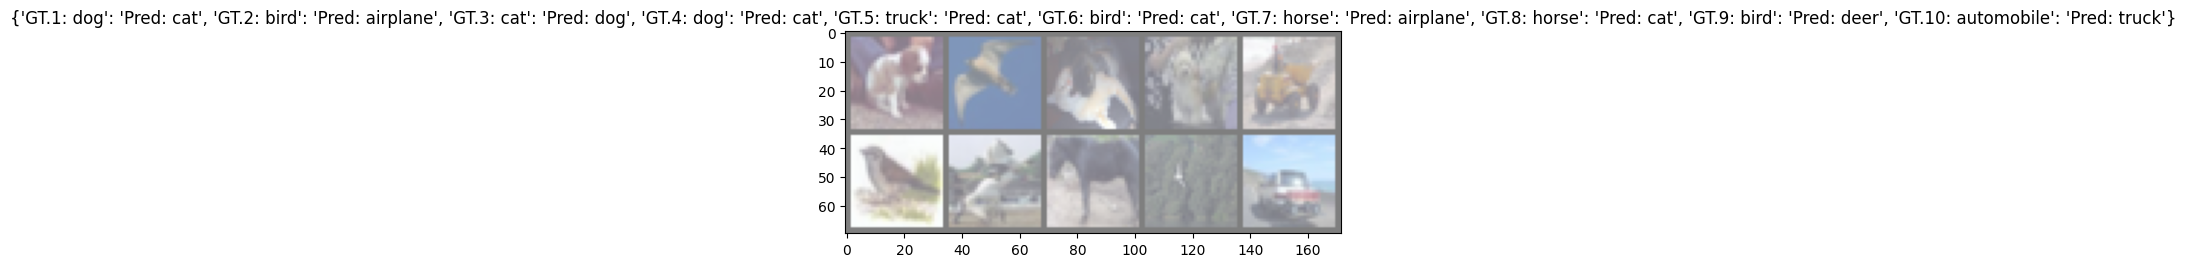

In [ ]:
imshow(grid_image, misclassified_dict)